# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget
#%matplotlib inline
#%load_ext autoreload

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
mp3_fpa_df_unique['date'] = pd.to_datetime(mp3_fpa_df_unique['Date (FGC)']).dt.strftime('%Y-%m-%d')

len(mp3_fpa_df)

3981

# Read metadata

In [5]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,age,Manufacturer,Inner cable type,Outer cable type,I_Q_SM18,Renamed short magnet ID,MTF Status,Magnet_construction_order,QPS Crate Number,Cryostat Number
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,14.0,3.0,01B,02B8,11488.0,NaN,NaN,288,0,0
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,14.0,2.0,01E,02C0,10622.0,NaN,NaN,256,0,1
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,14.0,2.0,01E,02C9,12427.0,NaN,NaN,330,1,0
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,14.0,2.0,01E,02C9,11155.0,NaN,NaN,319,2,1
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,14.0,1.0,01E,02B8,11782.0,NaN,NaN,296,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,14.0,3.0,01B,02G,12645.0,NaN,NaN,123,1,1
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,14.0,1.0,01B,02B5,12379.0,NaN,NaN,62,1,0
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,14.0,2.0,01B,02K,11757.0,NaN,NaN,61,2,1
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,14.0,3.0,01B,02G,11656.0,NaN,NaN,172,0,0


# Get all events

In [6]:
from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
warnings.filterwarnings('ignore')

In [7]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()

all_fpa_identifiers = mp3_fpa_df.fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=all_fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['el_position_feature','event_feature'])

In [8]:
# all events with successfully loaded data
fpa_identifiers = all_fpa_identifiers[np.isin(all_fpa_identifiers, dataset_1EE.event.values)] 

# exclude events with fast secondary quenches
bool_fast = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 0.6) & (mp3_fpa_df['Nr in Q event'].astype(str) !='1')) 
            
fpa_identifiers_fast = fpa_identifiers[np.isin(fpa_identifiers, mp3_fpa_df[bool_fast].fpa_identifier.unique())]

bool_train = ~np.isin(fpa_identifiers, fpa_identifiers_fast)
fpa_identifiers_train = fpa_identifiers[bool_train]

print(len(fpa_identifiers_train), len(fpa_identifiers_fast))

432 128


In [9]:
data = dataset_1EE['data'].loc[{'event': fpa_identifiers_train}].rolling(time=21, center=True).mean()  # time=21 -> 20ms rolling mean filter
data_norm = data - data.mean(axis=1, skipna=True)
data_max = data_norm.max(axis=-1, skipna=True)

In [10]:
metadata_columns = ['Short magnet ID', 'Circuit', 'Magnet', 'Phys. Position', 'El. Position']
df_results = rb_magnet_metadata[metadata_columns].sort_values(by=['Circuit', 'El. Position'], ignore_index=True)
for fpa_identifier in fpa_identifiers_train:
    date = mp3_fpa_df_unique[mp3_fpa_df_unique.fpa_identifier ==fpa_identifier].date.values[0]
    circuit = fpa_identifier.split("_")[1]
    df_results.loc[df_results.Circuit==circuit, f"{date}_{fpa_identifier}"] = data_max.loc[{'event': fpa_identifier}]

In [11]:
event_columns = df_results.drop(columns=metadata_columns).columns.to_list()
df_results["max_em_disturbance"] = df_results[event_columns].max(axis=1)
df_results[metadata_columns + ["max_em_disturbance"] + event_columns] #.to_csv("max_em_disturbance.csv")

,Short magnet ID,Circuit,Magnet,Phys. Position,El. Position,max_em_disturbance,2018-12-03_RB_RB.A12_1543810849860000000,2018-12-07_RB_RB.A12_1544193969420000000,2018-12-11_RB_RB.A12_1544517631800000000,2018-10-31_RB_RB.A45_1540946196440000000,...,2021-11-09_RB_RB.A78_1636458588500000000,2021-11-10_RB_RB.A78_1636527821260000000,2021-11-10_RB_RB.A78_1636569544760000000,2021-11-11_RB_RB.A78_1636654131900000000,2021-11-12_RB_RB.A78_1636698940740000000,2021-11-12_RB_RB.A78_1636740012620000000,2021-11-13_RB_RB.A78_1636806661040000000,2021-11-14_RB_RB.A78_1636875606280000000,2021-11-15_RB_RB.A78_1636956514140000000,2021-11-15_RB_RB.A78_1637002549840000000
0,2401,RB.A12,MB.A8L2,154,1,0.146784,0.061454,-0.023305,-0.033284,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3390,RB.A12,MB.A9L2,152,2,0.395671,NaN,-0.043005,-0.051663,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2374,RB.A12,MB.A10L2,150,3,0.424966,0.007789,-0.033358,-0.034697,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2359,RB.A12,MB.A11L2,148,4,0.787431,0.017986,0.000410,0.002633,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2369,RB.A12,MB.A12L2,146,5,0.021642,-0.023865,-0.022867,-0.022355,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,3159,RB.A81,MB.A12R8,9,150,0.002876,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1228,3166,RB.A81,MB.A11R8,7,151,0.055048,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1229,3169,RB.A81,MB.A10R8,5,152,0.024738,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1230,3056,RB.A81,MB.A9R8,3,153,0.067956,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

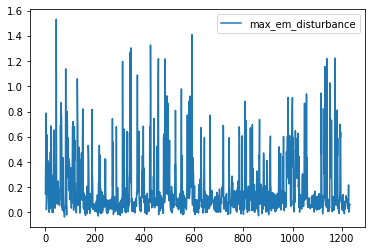

In [12]:
df_results.plot(y=["max_em_disturbance"])

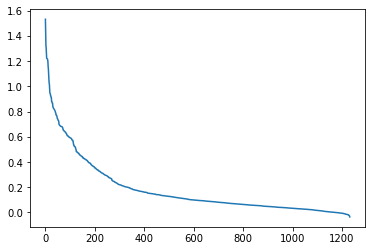

In [13]:
plt.plot(df_results["max_em_disturbance"].sort_values(ascending=False).values)

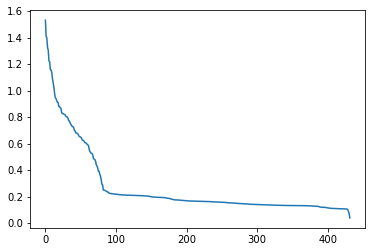

In [14]:
plt.plot(df_results[event_columns].max(axis=0).sort_values(ascending=False).values)
